# Imports

In [1]:
import copy as cp
import csv
import math
import os
import sys
from datetime import datetime
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
import jdc
import time
from statistics import mean
import pickle
import itertools
from csv import writer

# Utility Methods

In [2]:
def calcDurationInHours(starting_time, ending_time):
    return (ending_time - starting_time).total_seconds() / 60 / 60

In [3]:
def time_convert(sec):
    mins = sec // 60
    sec = sec % 60
    hours = mins // 60
    mins = mins % 60
    print("Time Lapsed = {0}:{1}:{2}".format(int(hours),int(mins),sec))

# Objects

In [4]:
class Flights(object):
    __slots__ = 'legNo', 'airport_departure', 'date_departure', 'hour_departure', 'airport_arrival', 'date_arrival', 'hour_arrival', 'date_time_arrival', 'date_time_departure', 'duration'
    def __int__(self):
        self.legNo = self.legNo
        self.airport_departure = self.airport_departure
        self.date_departure = self.date_departure
        self.hour_departure = self.hour_departure
        self.airport_arrival = self.airport_arrival
        self.date_arrival = self.date_arrival
        self.hour_arrival = self.hour_arrival
        self.date_time_departure = self.date_time_departure
        self.date_time_arrival = self.date_time_arrival
        self.duration = self.duration
        # self.pairing_relation = self.pairing_relation

    def setDateTime(self):
        self.date_time_departure = datetime.strptime(str(self.date_departure + ' ' + self.hour_departure), "%Y-%m-%d "
                                                                                                           "%H:%M")
        self.date_time_arrival = datetime.strptime(str(self.date_arrival + ' ' + self.hour_arrival), "%Y-%m-%d %H:%M")
        diff = self.date_time_arrival - self.date_time_departure
        seconds_in_hours = diff.seconds / 60 / 60
        days_in_hours = diff.days * 24
        self.duration = seconds_in_hours + days_in_hours

    def __eq__(self, other):
        return self.legNo == other.legNo

    def __hash__(self):
        return hash(('legNo', self.legNo))

In [5]:
# class Duties(object):
#     id = 0
#     newId = itertools.count()
#     legs: list[Flights] = []
#     start_date_time = None
#     end_date_time = None
#     starting_airport = ""
#     ending_airport = ""
#     total_flying_time = 0
#     total_duration = 0
#
#     def __init__(self, legs: list[Flights]):
#         self.id = next(self.newId)
#         dur = 0
#         self.legs = legs
#         self.start_date_time = legs[0].date_time_departure
#         self.end_date_time = legs[-1].date_time_arrival
#         self.starting_airport = legs[0].airport_departure
#         self.ending_airport = legs[-1].airport_arrival
#         for l3g in legs:
#             dur += (l3g.date_time_arrival-l3g.date_time_departure).total_seconds()/60/60
#         self.total_flying_time = dur
#         self.total_duration = (self.end_date_time - self.start_date_time).total_seconds() / 60 / 60

In [6]:
class Pairings(object):

    __slots__ = "legs" , "total_flying_time", "set_flights", "start_date_time", 'end_date_time', 'id', 'base_airport', 'total_duration', 'pairing_string', 'cost'

    def __init__(self, fls: list[Flights]):
        self.legs = []
        self.cost = -1
        self.id = -1
        self.legs = fls
        temp_flying_time = 0
        for l3g in self.legs:
            temp_flying_time += calcDurationInHours(l3g.date_time_departure, l3g.date_time_arrival)
        self.total_flying_time = temp_flying_time

        self.set_flights = set([l3g.legNo for l3g in self.legs])

        # self.total_flying_time += dty.total_flying_time
        self.start_date_time = self.legs[0].date_time_departure
        self.end_date_time = self.legs[-1].date_time_arrival
        self.base_airport = self.legs[0].airport_departure
        # self.total_flying_time = reduce(mul, [x.total_flying_time for x in duties])
        self.total_duration = calcDurationInHours(self.start_date_time, self.end_date_time)
        disp = ""
        for l3g in self.legs:
            disp += l3g.legNo + " , "
        self.pairing_string = disp[:len(disp) - 3]

    def __eq__(self, other):
        return self.pairing_string == other.pairing_string

    def __hash__(self):
        return hash(('pairing_string', self.pairing_string))

In [7]:
class Airport(object):
    name = ""
    is_base = None

    def __init__(self):
        self.name = self.name
        self.is_base = self.is_base

In [8]:
class PairingAlt(object):
    pairing_name = ""
    base = ""
    legs = {}
    start_date = ""
    start_time = ""
    end_date = ""
    end_time = ""
    total_flying_time = ""
    total_duration = 0

    def __int__(self):
        self.pairing_name = self.pairing_name
        self.base = self.base
        self.legs = self.legs
        self.start_date = self.start_date
        self.start_time = self.start_time
        self.end_date = self.end_date
        self.end_time = self.end_time
        self.total_flying_time = self.total_flying_time
        self.total_duration = self.total_duration

In [9]:
class Solution(object):
    id = ""
    solution_pairings = []
    solution_cost = 0
    deadheads = 0
    gen_time = 0
    died_time = 0
    generationMethod = -1

    solution_encoding = []
    parents = []

    def __init__(self):
        self.id = -1
        self.solution_pairings = []
        self.solution_cost = 0
        self.deadheads = 0
        self.gen_time = 0
        self.solution_encoding = []
        self.parents = []
        self.generationMethod = "Random Generation"

# Input

In [10]:
instanceNum = 0
allowedRatio = 0
err = True
while err:

    try:
        instanceNum = int(input("Which instance would you like to use?"))
        allowedRatio = float(input("What is the allowed ratio of flight time : total time (in percent)"))
        if 8 > instanceNum > 0 >= allowedRatio >= 100:
            err = True
        else:
            err = False
    except:
        err = True

    if err:
        print("Instance Number between 1 and 7, both included and allowed ratio must be greater than 0 and smaller that 100")
        instanceNum = 0


# File Reading

In [11]:
flights = {}
tempFlights = []
for day in range(31):
    path = os.getcwd() + '\instance'+ str(instanceNum) + '\day_' + str(day + 1) + '.csv'
    first = True
    with open(path) as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
            if not row:
                continue
            elif first:
                first = False
                continue
            elif len(row) <= 6:
                continue
            else:
                f = Flights()
                f.legNo = row[0].strip()
                f.airport_departure = row[1].strip()
                f.date_departure = row[2].strip()
                f.hour_departure = row[3].strip()
                f.airport_arrival = row[4].strip()
                f.date_arrival = row[5].strip()
                f.hour_arrival = row[6].strip()
                key = str(f.legNo.strip())
                # covered[key] = (False, 0)
                f.setDateTime()
                tempFlights.append(f)


# Taken from Zammit (2019)'s Solution as this was the value he used to fill in the missing part of the dataset
if instanceNum == 3:
    new_flight = Flights()
    new_flight.legNo = 'LEG_31_38'
    new_flight.airport_departure = 'BASE1'
    new_flight.date_departure = '2000-01-30'
    new_flight.hour_departure = '01:20'
    new_flight.airport_arrival = 'AIR30'
    new_flight.date_arrival = '2000-01-30'
    new_flight.hour_arrival = '02:33'
    new_flight.setDateTime()
    tempFlights.append(new_flight)

tempFlights.sort(key=lambda x: x.date_time_arrival, reverse=False)
for flight in tempFlights:
    flights[flight.legNo] = flight

In [12]:
genesisPair = []
path = os.getcwd() + '\instance'+ str(instanceNum) + '\initialSolution.in'
with open(path) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    for row in reader:
        # print(row)
        # print('----------------------------')
        if not row:
            continue
        elif len(row[0]) <= 15:
            #  Do not do anything if the row is does not contain pairing information
            continue
        else:
            P = PairingAlt()
            main_index = row[0].find(': Base')  # Setting the index as a limit on which to extract string of row
            P.pairing_name = row[0][0: main_index - 1].strip()
            # Setting the index as a limit on which to extract string of row
            if 'TDH' in row[0]:
                main_index = row[0].find(': TDH')
            else:
                main_index = row[0].find(': LEG')
            sub_index = row[0].find('BASE')  # Getting starting index from which to extract
            P.base = row[0][sub_index:main_index - 1].strip()
            num = len(row[1:])

            holder = [row[0][main_index + 1:].strip()]
            for n in range(num):
                if ';' in row[n + 1]:
                    holder.append(row[n + 1][0:-1].strip())
                else:
                    holder.append(row[n + 1].strip())

            P.legs = holder
            key = str(P.pairing_name.strip())  # Key prefixed with instance number

            #  Setting Key for flight search
            firstLeg = str(P.legs[0])
            lastLeg = str(P.legs[-1])

            #  Removing TDH when searching for a Key
            if 'TDH_' in firstLeg:
                firstLeg = firstLeg.replace("TDH_", "")
            P.start_date = flights[firstLeg].date_departure
            P.start_time = flights[firstLeg].hour_departure
            if 'TDH_' in lastLeg:
                lastLeg = lastLeg.replace("TDH_", "")
            P.end_date = flights[lastLeg].date_arrival
            P.end_time = flights[lastLeg].hour_arrival

            # Calculating the credited flying time for a pairing
            total_flying_time = 0
            for k, p in enumerate(P.legs):
                if 'TDH' in p:
                    p = p.replace("TDH_", "")
                    P.legs[k] = p.replace("TDH_", "")
                total_flying_time += flights[p].duration
            P.total_flying_time = total_flying_time
            P.total_duration = calcDurationInHours(flights[P.legs[0]].date_time_departure, flights[P.legs[-1]].date_time_arrival)

            genesisPair.append(P)
            print(P.legs)

['LEG_11_12', 'LEG_12_4', 'LEG_12_16', 'LEG_12_46', 'LEG_12_2', 'LEG_12_9', 'LEG_13_51', 'LEG_13_6', 'LEG_13_11']
['LEG_17_22', 'LEG_17_26', 'LEG_17_24', 'LEG_17_36', 'LEG_18_37', 'LEG_18_0', 'LEG_18_14', 'LEG_18_13', 'LEG_19_21', 'LEG_19_18', 'LEG_19_5', 'LEG_19_42', 'LEG_20_4', 'LEG_20_15', 'LEG_20_18', 'LEG_20_21', 'LEG_20_20', 'LEG_20_23']
['LEG_17_40', 'LEG_17_41', 'LEG_18_54', 'LEG_18_55', 'LEG_18_40', 'LEG_18_41', 'LEG_19_46', 'LEG_19_49', 'LEG_19_40', 'LEG_20_45', 'LEG_20_3', 'LEG_20_5']
['LEG_17_28', 'LEG_17_33', 'LEG_17_31', 'LEG_17_42', 'LEG_17_62']
['LEG_17_63', 'LEG_17_8']
['LEG_17_5', 'LEG_17_61']
['LEG_17_46', 'LEG_17_43']
['LEG_17_58', 'LEG_17_18']
['LEG_01_5', 'LEG_01_9', 'LEG_01_10', 'LEG_02_1', 'LEG_02_21', 'LEG_02_28', 'LEG_03_21', 'LEG_03_26', 'LEG_03_24', 'LEG_03_36', 'LEG_04_37', 'LEG_04_16', 'LEG_04_25']
['LEG_01_14', 'LEG_01_23', 'LEG_01_24', 'LEG_01_22', 'LEG_01_32', 'LEG_02_36']
['LEG_13_13', 'LEG_14_35', 'LEG_14_34', 'LEG_14_17', 'LEG_14_7', 'LEG_14_11']
['L

In [13]:
airports = {}
path = os.getcwd() + '\instance' + str(instanceNum) + '\listOfBases.csv'
with open(path) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    first = True
    for row in reader:
        if not first:
            a = Airport()
            a.name = row[0].strip()
            if int(row[1]):
                a.is_base = True
                # bases[a.name] = a
            else:
                a.is_base = False
            airports[a.name] = a
        else:
            first = False

# Graph

In [14]:
g = nx.DiGraph()

In [15]:
for airport in airports.keys():
    g.add_node(airport)

In [16]:
for flight in flights.items():
    day = int(flight[1].legNo[4:6])
    if not g.has_edge(flight[1].airport_departure, flight[1].airport_arrival):
        g.add_edge(flight[1].airport_departure, flight[1].airport_arrival, flight_list = {f"{flight[1].legNo}": (flight[1], False, day)}, weight=flight[1].duration)
    else:
        orig = g[flight[1].airport_departure][flight[1].airport_arrival]["flight_list"]
        orig[flight[1].legNo] = (flight[1], False, day)
        new_attr = {(flight[1].airport_departure, flight[1].airport_arrival) : {"flight_list" : orig}}
        nx.set_edge_attributes(g, new_attr)

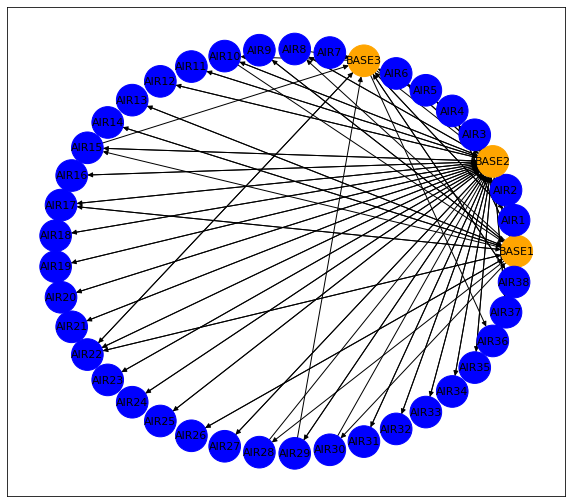

In [17]:
pos = nx.circular_layout(g)
c_m = {}
for item in airports.items():
    if item[1].is_base:
        c_m[item[1].name] = "orange"
    else:
        c_m[item[1].name] = "blue"
colors = [c_m.get(node) for node in g.nodes()]
plt.figure(figsize= (10,9))
nx.draw_networkx(g, pos, node_size=1000, font_size=11, node_color=colors)

# Covering Flights Code

In [18]:
def init_cover_list() -> dict:
    cvrd = {}
    for fl in flights:
        cvrd[fl] = (False, 0)
    return cvrd

In [19]:
def getNonCoveredFlights(cvrd) -> list[Flights]:
    not_covered_flights = []
    for cov in cvrd.items():
        if not cov[1][0]:
            # print(cov)
            not_covered_flights.append(cov)
    return not_covered_flights

In [20]:
def checkCovered(cvd) -> bool:
    covrd = True
    # counter = 0
    for it in cvd.items():
        if not it[1][1]:
            covrd = False
            break
            # counter+=1
    # print(counter)
    return covrd

# Pairing Generation

In [21]:
def validPairing(curr: list[Flights]) -> tuple[int, int]:
    kp = 1
    ct = 1
    # length_curr = len(curr)
    tempP = Pairings(curr)
    # if tempP.pairing_string == "LEG_06_3 , LEG_06_31 , LEG_06_30 , LEG_07_10 , LEG_07_11 , LEG_07_19":
    #     print()
    # if tempP.pairing_string == "LEG_06_3 , LEG_06_31 , LEG_06_30 , LEG_07_10":
    #     print()

    if list_of_non_cvrd is not None:
        # set_of_non_covered = set(list_of_non_cvrd)
        continueSearching = False
        for fl in list_of_non_cvrd:
            if calcDurationInHours(curr[0].date_time_departure, flights[fl].date_time_arrival) < 72:
                continueSearching = True
        if not continueSearching:
            return 0,0


    if tempP.total_flying_time / tempP.total_duration * 100 < allowedRatio:
        kp = 0

    if tempP.base_airport != curr[-1].airport_arrival:
        kp = 0

    if tempP.total_duration > 72:
        return 0, 0

    dateTimer = 0
    flightTimer = 0

    reversedCurr = [curr[j] for j in range(len(curr) - 1, -1, -1)]
    for j, fl in enumerate(reversedCurr):
        flightTimer += fl.duration
        dateTimer += fl.duration

        if j != 0:
            flight_diff = calcDurationInHours(fl.date_time_arrival, reversedCurr[j-1].date_time_departure)
            if flight_diff < 0.25:
                return 0,0


            if dateTimer + flight_diff > 14 and flight_diff < 10:
                return 0,0
            elif flight_diff > 10:
                break
            else:
                dateTimer += flight_diff

            # if dateTimer + flight_diff > 14:
            #     if flight_diff < 10:
            #         return 0, 0
            #     else:
            #         break
            # else:
            #     dateTimer += flight_diff

        if flightTimer > 8:
            return 0,0

    return kp, ct

In [22]:
def searchPairings(current: list[Flights], pairings: list[Pairings]) -> list[Pairings]:
    keep, cont = validPairing(current)
    if keep:
        pair = Pairings(cp.deepcopy(current))
        pairings.append(pair)
    if cont:
        first_leg = current[0]
        last_leg = current[-1]
        for ed in g.out_edges(last_leg.airport_arrival):
            for fl_ed in g[ed[0]][ed[1]]["flight_list"].items():
                f_inner : Flights = fl_ed[1][0]
                if calcDurationInHours(first_leg.date_time_departure, f_inner.date_time_arrival) > 72:
                    break
                if calcDurationInHours(last_leg.date_time_arrival, f_inner.date_time_departure) >= 0.25:
                    current.append(f_inner)
                    pairings = searchPairings(current, pairings)
                    current.remove(f_inner)
    return pairings

In [23]:
def calcPairingCost(p_toCalc: Pairings) -> float:
    return math.floor(1000*p_toCalc.total_duration/p_toCalc.total_flying_time)

In [25]:
all_pairings = []

list_of_non_cvrd = None
for airport in airports.items():
    air = airport[1]
    air: Airport
    if air.is_base:
        print("Base: ", air.name, sep="")
        for edge in g.out_edges(air.name):
            print("Generating pairings for ", edge, sep="")
            beforeNew = len(all_pairings)
            for flight in g[edge[0]][edge[1]]["flight_list"].items():
                f : Flights = flight[1][0]
                # print(f.legNo)
                new_pairings = searchPairings([f], [])

                all_pairings.extend(new_pairings)

            if beforeNew == len(all_pairings):
                tempRatio = allowedRatio
                allowedRatio = 0
                for flight in g[edge[0]][edge[1]]["flight_list"].items():
                    f : Flights = flight[1][0]
                    # print(f.legNo)
                    new_pairings = searchPairings([f], [])

                    all_pairings.extend(new_pairings)
                # new_pairings = searchPairings([f], [])
                allowedRatio = tempRatio
            print("Pairings Generated = ", len(all_pairings) - beforeNew, sep="")
        print("---------------")

Base: BASE1
Generating pairings for ('BASE1', 'AIR9')


KeyboardInterrupt: 

In [26]:
len(all_pairings)

153859

In [ ]:
covered = init_cover_list()
empty_covered = {}
# for pairing in all_pairings:
#     pairing : Pairings
#     for leg in pairing.legs:
#         covered[leg.legNo] = (True, covered[leg.legNo][1]+1)

for pairing in all_pairings:
    intersec = pairing.set_flights.intersection(empty_covered)
    if len(intersec) != len(pairing.legs):
        for f in pairing.legs:
            if f.legNo not in empty_covered:
                empty_covered[f.legNo] = (True, 1)
    if len(empty_covered) == len(flights):
        break

for item in empty_covered.items():
    if item[0] in empty_covered:
        item = (True, 1)

non_covrd = getNonCoveredFlights(empty_covered)
if len(non_covrd) != 0:
    print(non_covrd)
    list_of_non_cvrd = [e[0] for e in non_covrd]
    allowedRatio = 0
    for airport in airports.items():
        air = airport[1]
        air: Airport
        if air.is_base:
            print(air.name)
            for edge in g.out_edges(air.name):
                print(edge)
                beforeNew = len(all_pairings)
                for flight in g[edge[0]][edge[1]]["flight_list"].items():
                    delete = True
                    f : Flights = flight[1][0]

                    new_pairings = searchPairings([f], [])
                    temp_new_pairings = new_pairings[:]
                    for p in new_pairings:
                        for leg in p.legs:
                            if leg.legNo in list_of_non_cvrd:
                                delete = False
                        if delete:
                            temp_new_pairings.remove(p)
                    all_pairings.extend(temp_new_pairings)
                print("Pairings Generated = ", len(all_pairings) - beforeNew, sep="")
                print("--")
    for pairing in all_pairings:
        pairing : Pairings
        for leg in pairing.legs:
            covered[leg.legNo] = (True, covered[leg.legNo][1]+1)
    non_covrd = getNonCoveredFlights(covered)

if len(non_covrd) != 0:
    print("Parameters are impossible")

In [ ]:
# backup = all_pairings[:]
flight_pairings : {str:list[Pairings]} = {}
# # seen_pairings = set()
# temp_new_pairings = all_pairings[:]
# all_pairings = []

for i, obj in enumerate(all_pairings):
    # if obj.pairing_string not in seen_pairings:
    #     all_pairings.append(obj)
    #     seen_pairings.add(obj.pairing_string)
    all_pairings[i].cost = calcPairingCost(obj)
    for f in obj.legs:
        if f.legNo in flight_pairings:
            flight_pairings[f.legNo].append(obj)
        else:
            flight_pairings[f.legNo] = [obj]


print("Total Pairings Generated: ", len(all_pairings), sep="")

In [ ]:
# invalid = 0
# for p in all_pairings:
#     full_timer = 0
#     flight_timer = 0
#     flightDiff = 0
#     for i, f in enumerate(p.legs):
#         full_timer += f.duration
#         flight_timer += f.duration
#
#
#         if i != 0:
#             flightDiff = calcDurationInHours(p.legs[i-1].date_time_arrival, f.date_time_departure)
#             full_timer += flightDiff
#
#         if flightDiff < 10 and full_timer > 14:
#             invalid += 1
#             print(p.pairing_string)
#         elif flightDiff > 10:
#             full_timer = 0
#             flight_timer = 0


In [ ]:
# backup_pairings = all_pairings[:]

In [ ]:
for plst in flight_pairings.items():
    flight_pairings[plst[0]] = set(plst[1])

In [ ]:
avg = mean([item.cost for item in all_pairings])
counter = 0
temp_new_pairings = all_pairings[:]
new_pairings = []

for i, p in enumerate(temp_new_pairings):
    rem = True
    count = min([len(flight_pairings[f.legNo]) for f in p.legs])
    if count < 100:
        rem = False

    if rem:
        counter += 1
        for f in p.legs:
            flight_pairings[f.legNo].remove(p)
    else:
        new_pairings.append(p)

In [ ]:
new_pairings.sort(key=lambda x:x.cost, reverse=False)
all_pairings = new_pairings

In [ ]:
len(new_pairings)

In [ ]:
for p in all_pairings:
    p.cost = calcPairingCost(p)
all_pairings.sort(key=lambda xt: xt.cost, reverse=False)

for i, p in enumerate(all_pairings):
    p.id = i

In [ ]:
genesisPairActual = Solution()
update = False
for P in genesisPair:
    match_length = len(P.legs)
    set_legs = set(P.legs)

    find = False
    for item in flight_pairings[P.legs[0]]:
        if len(set(P.legs).intersection(item.set_flights)) == match_length and len(item.set_flights) == len(P.legs):
            find = True
            genesisPairActual.solution_pairings.append(item)
    if not find:
        print("".join([leg + " , " for leg in P.legs]))
        print(P.legs)
        print("---------------------")
        ls = [flights[leg] for leg in P.legs]
        all_pairings.append(Pairings(ls))
        genesisPairActual.solution_pairings.append(all_pairings[-1])
        update = True

if update:
    for p in all_pairings:
        p.cost = calcPairingCost(p)
    all_pairings.sort(key=lambda xt: xt.cost, reverse=False)

    for i, p in enumerate(all_pairings):
        p.id = i

    flight_pairings = {}
    for p in all_pairings:
        for f in p.legs:
            if f.legNo in flight_pairings:
                flight_pairings[f.legNo].append(p)
            else:
                flight_pairings[f.legNo] = [p]


In [ ]:
# msg = []
# pop_dict = {}
# for i, pairing in enumerate(all_pairings):
#     pairing: Pairings
#     display = ""
#     for leg in pairing.legs:
#         display += leg.legNo + " , "
#     msg.append("".join(["Pairing ", str(i + 1), ": ", display[:len(display) - 2]]))
#     msg.append("".join(["Total Time:", str(pairing.total_duration)]))
#     msg.append("".join(["Total Flying Time:", str(pairing.total_flying_time)]))
#     msg.append("--------------")
#
# with open('pairings.txt', 'w', encoding='utf-8') as file:
#     file.write('\n'.join(msg))

# print("Total Pairings:", len(all_pairings))

In [ ]:
with open('PairingObjects/PairingObjects'+ str(instanceNum) +'.txt', 'wb') as pairings_file:
    pickle.dump(all_pairings, pairings_file)

In [ ]:
# with open('pairingsObject.txt', 'rb') as pairings_file:
#     backup_pairings = pickle.load(pairings_file)

# Initial Population Code

In [ ]:
def checkSimilarity(cvd, t_pairing: Pairings) -> int:
    total_legs = len(t_pairing.legs)
    present_legs = 0
    for Leg in t_pairing.legs:
        if cvd[Leg.legNo][0]:
            present_legs += 1
    return present_legs/total_legs * 100

In [ ]:
def returnFeasibleSolution(curr_sol: Solution):
    if len(curr_sol.solution_pairings) == 0:
        curr_sol.solution_pairings = convertFromBinaryToPairings(to_convert=curr_sol.solution_encoding)
    cov = init_cover_list()
    for pair in curr_sol.solution_pairings:
        for fl in pair.legs:
            cov[fl.legNo] = (True, cov[fl.legNo][1]+1)
    non_covered = getNonCoveredFlights(cov)
    list_of_non_covered =[e[0] for e in non_covered]
    set_of_non_covered = set(list_of_non_covered)


    for fl in list_of_non_covered:
        if fl in set_of_non_covered:
            candidates = []
            temp_pairings = list(flight_pairings[fl])
            for pair in temp_pairings:
                potential_cover = len(set_of_non_covered.intersection(pair.set_flights))
                candidates.append((pair, 1.0*pair.cost/potential_cover))
            candidates.sort(key=lambda x: x[1], reverse=False)
            curr_sol.solution_pairings.append(candidates[0][0])
            if len(curr_sol.solution_encoding)!= 0:
                curr_sol.solution_encoding[candidates[0][0].id] = 1
            for l3g in candidates[0][0].legs:
                if l3g.legNo in set_of_non_covered:
                    set_of_non_covered.remove(l3g.legNo)

    curr_sol = clearUnusedPairings(curr_sol)
    return curr_sol

In [ ]:
def clearUnusedPairings(curr_sol) -> Solution:
    cov = init_cover_list()
    curr_sol.solution_pairings.sort(key=lambda xt: xt.cost, reverse=False)
    new_list = []
    for j, pair in enumerate(curr_sol.solution_pairings):
        remove = True
        for fl in pair.legs:
            if cov[fl.legNo][0] is False:
                remove = False
                cov[fl.legNo] = (True, None)
        if remove:
            # curr_sol.solution_pairings.remove(pair)
            if len(curr_sol.solution_encoding)!= 0:
                curr_sol.solution_encoding[pair.id] = 0
        else:
            new_list.append(pair)
    curr_sol.solution_pairings = new_list
    return curr_sol

In [ ]:
def find_random_solution():
    solution = Solution()
    covered_flights = init_cover_list()
    temp_pairings = all_pairings[:]
    while len(temp_pairings)!= 0:
        index = random.randint(0, len(temp_pairings)-1)
        if len(solution.solution_pairings) == 0:
            solution.solution_pairings.append(temp_pairings[index])
            for Leg in temp_pairings[index].legs:
                covered_flights[Leg.legNo] = (True, covered_flights[Leg.legNo][1]+1)
        else:
            sim = checkSimilarity(covered_flights, temp_pairings[index])
            if sim == 0:
                solution.solution_pairings.append(temp_pairings[index])
                for Leg in temp_pairings[index].legs:
                    covered_flights[Leg.legNo] = (True, covered_flights[Leg.legNo][1]+1)
        del temp_pairings[index]
    return returnFeasibleSolution(solution)

In [ ]:
def calcDeadheadsFromCover(cov):
    j = 0
    for it in cov.items():
        # print(item)
        if it[1][1] > 1:
            j+=(it[1][1]-1)
    return j

In [ ]:
def calcDeadheadsAlt(sol):
    j = 0
    cov = init_cover_list()
    for pr in sol:
        for Leg in pr.legs:
            cov[Leg] = (True, cov[Leg][1]+1)
    for it in cov.items():
        # print(item)
        if it[1][1] > 1:
            j+=(it[1][1]-1)
    return j

In [ ]:
def calcDeadheadsFromSolution(sol: list[Pairings]):
    j = 0
    cov = init_cover_list()
    for pr in sol:
        for Leg in pr.legs:
            cov[Leg.legNo] = (True, cov[Leg.legNo][1]+1)
    for it in cov.items():
        # print(item)
        if it[1][1] > 1:
            j+=(it[1][1]-1)
    return j

In [ ]:
def calcSolutionCost(pairs: list[Pairings], deadheads:int) -> float:
    c = 0
    for pr in pairs:
        c+=calcPairingCost(pr)
    c+= deadheads*1000
    return c

In [ ]:
# covered_list = []
# pre_population = []
def generatePop(num_of_Solutions: int, prnt=True):
    temp_solutions = []
    for j in range(num_of_Solutions):
        if prnt:
            print("Solution", j+1, sep=" ", end= "\n")
        s = find_random_solution()
        s.id = j
        s.deadheads = calcDeadheadsFromSolution(s.solution_pairings)
        s.solution_cost = calcSolutionCost(s.solution_pairings, s.deadheads)
        if prnt:
            print("Deadheads: ", s.deadheads, sep="")
            print("Solution Length: ", len(s.solution_pairings), sep="")
            print("Solution Cost: ", s.solution_cost, sep="")
        temp_solutions.append(s)
        
    return temp_solutions

pre_population = generatePop(100)


In [ ]:
# GA generate 100 solutions randomly -- done
# Genesis solution has to be one of the starting 100 -- can be done
# Shall always use the best solutions for the following (The best 10 must ALWAYS go in)
# have a way of determining if a solution is valid or not. //Genetic repair to fix it
#   crossover operator - from the solution ex. you get one pairing from one and another and you star picking from one to another and you do it until a certain point you must repair it.
# Genetic operators are SUPER important
# fitness func use cost
# take the init population and create another 500 from crossover, order them by cost, create another 100 and use prob tournament
# take another population

#VIMP -- Every solution has to be a unique code - to track if a solution makes it from solution to solution and how it was born and how it died. Some will survive but won't be the best and we must know this. -- solution object created

# how many at each generation are new, average lifespan - lower the better as you are getting better ones.

## Genetic Algorithm

In [ ]:
def convertFromPopulationToBinary(pop):
    blank_gene = [0 for _ in all_pairings]

    for sol in pop:
        sol.solution_encoding = blank_gene[:]
        for pair in sol.solution_pairings:
            #Just in case assignment went wrong
            if not hasattr(pair, "id"):
                hold = None
                found = False
                for searcher in all_pairings:
                    if pair.end_date_time == searcher.end_date_time and searcher.cost == pair.cost and searcher.start_date_time == pair.start_date_time:
                        if not found:
                            hold = searcher
                            found = True
                        else:
                            found= False
                            break
                if found:
                    sol.solution_encoding[hold.id] = 1
                else:
                    print("Fatal error")
            else:
                sol.solution_encoding[pair.id] = 1

In [ ]:
def convertFromBinaryToPairings(to_convert : list[int]):
    temp_sol = []
    for j, binary in enumerate(to_convert):
        if binary == 1:
            temp_sol.append(all_pairings[j])
    return temp_sol

In [ ]:
class GeneticAlgorithm:
    min_generations = 0
    generation_num = 0
    mutation_rate = 0
    initial_GA_population = 100
    population: list[Solution] = []
    pop_copy: list[Solution] = []
    threshold = -sys.maxsize
    crossover_rate = 0
    max_generations = 0
    curr_gen = 0
    # total_kept = 0

    def __init__(self, min_generations, mutation_rate, initial_population, threshold, crossover_rate, max_generations):
        self.min_generations = min_generations
        self.mutation_rate = mutation_rate
        self.population = initial_population[:]
        self.pop_copy = initial_population[:]
        self.threshold = threshold
        self.crossover_rate = crossover_rate
        self.max_generations = max_generations
        self.curr_gen = 0
        # self.total_kept = 0

In [ ]:
    %%add_to GeneticAlgorithm
    def sort_by_cost(self):
        self.population.sort(key=lambda x: x.solution_cost, reverse=False)
        self.pop_copy.sort(key=lambda x: x.solution_cost, reverse=False)


In [ ]:
def mutate(child : Solution, rate, pre_run=False):
    # for j, binary in enumerate(child.solution_encoding):
    #     befBin = binary
    #     reciprocal = 1/len(child.solution_encoding)
    #     if binary == 0:
    #         child.solution_encoding[j] = int(random.choices([0,1], weights=[1-reciprocal, reciprocal], k=1)[0])
    #     else:
    #         child.solution_encoding[j] = int(random.choices([1,0], weights=[1-reciprocal, reciprocal], k=1)[0])
    #     # if befBin != child.solution_encoding[j]:
    #     #     print("Mutate!")
    if rate > len(child.solution_encoding):
        rate = len(child.solution_encoding)
    reciprocal = rate/len(child.solution_encoding)
    mutations = (random.choices([0,1], [1-reciprocal, reciprocal], k=len(child.solution_encoding))).count(1)
    for j in range(mutations):
        indx = random.randint(0, len(child.solution_encoding)-1)
        binary = child.solution_encoding[indx]
        if binary:
            child.solution_encoding[indx] = 0
        else:
            child.solution_encoding[indx] = 1
    if mutations != 0 and not pre_run:
        child.generationMethod = "Crossover and Mutation"
    return child

In [ ]:
def roulette_wheel_selection(GA) -> Solution:
    #reproduced from https://rocreguant.com/roulette-wheel-selection-python/2019/
    population_fitness = sum([chromosome.solution_cost for chromosome in GA.pop_copy])
    chromosome_probabilities = [chromosome.solution_cost/population_fitness for chromosome in GA.pop_copy]
    chromosome_probabilities.reverse()

    return np.random.choice(GA.pop_copy, p=chromosome_probabilities)

In [ ]:
#redundant
def fusion_crossover(parent1: Solution, parent2: Solution) -> Solution:
    curr_child: Solution = Solution()
    curr_child.solution_encoding = []
    if parent1.solution_cost <= parent2.solution_cost:
        fitter_parent = parent1
        other_parent = parent2
    else:
        fitter_parent = parent2
        other_parent = parent1

    probability = fitter_parent.solution_cost/(fitter_parent.solution_cost+other_parent.solution_cost)

    for fp,op in zip(fitter_parent.solution_encoding, other_parent.solution_encoding):
        if fp == 1 and op == 1:
            curr_child.solution_encoding.append(1)
        elif fp == 1 and op == 0 or fp == 0 and op == 1:
            curr_child.solution_encoding.append(random.choices([fp,op], weights=[1-probability, probability], k=1)[0])
        else:
            curr_child.solution_encoding.append(0)

    return curr_child


In [ ]:
# redundant
def uniform_crossover(parent1: Solution, parent2: Solution) -> Solution:
    curr_child: Solution = Solution()
    curr_child.solution_encoding = []
    for p1,p2 in zip(parent1.solution_encoding, parent2.solution_encoding):
        if p1 == 1 and p2 == 1:
            curr_child.solution_encoding.append(1)
        elif p1 == 1 and p2 == 0 or p1 == 0 and p2 == 1:
            chance = random.randint(1,100)
            if chance <= 50:
                curr_child.solution_encoding.append(1)
            else:
                curr_child.solution_encoding.append(0)
        else:
            curr_child.solution_encoding.append(0)

    return curr_child

In [ ]:
def single_point_crossover(parent1: Solution, parent2: Solution, crossover_point=None) -> (Solution, Solution):
    if crossover_point is None:
        min_point = len(parent1.solution_encoding)
        max_point = 0
        first_binary = True
        for j,b1,b2 in enumerate(zip(parent1.solution_encoding,parent2.solution_encoding)):
            if first_binary and b1 != b2:
                min_point = j
                first_binary = False
            elif b1 != b2 and not first_binary:
                max_point = j
        crossover_point = random.randint(min_point, max_point)
    curr_child_1 = Solution()
    curr_child_2 = Solution()
    curr_child_1.solution_encoding = parent1.solution_encoding[:]
    curr_child_2.solution_encoding = parent2.solution_encoding[:]

    for j in range(crossover_point,len(parent1.solution_encoding)):
        curr_child_1.solution_encoding[i],curr_child_2.solution_encoding[i] = curr_child_2.solution_encoding[i],curr_child_1.solution_encoding[i]

    return curr_child_1,curr_child_2


In [ ]:
def two_point_crossover(parent1: Solution, parent2: Solution) -> (Solution, Solution):
    min_point_1 = parent1.solution_encoding.index(1)
    min_point_2 = parent2.solution_encoding.index(1)

    # reversed_list_1 = parent1.solution_encoding[::-1]

    reversed_list_1 = [parent1.solution_encoding[j] for j in range(len(parent1.solution_encoding) - 1, -1, -1)]
    first_index_in_reversed_1 = reversed_list_1.index(1)
    last_index_1 = len(parent1.solution_encoding) -1 - first_index_in_reversed_1

    reversed_list_2 = [parent1.solution_encoding[j] for j in range(len(parent1.solution_encoding) - 1, -1, -1)]
    first_index_in_reversed_2 = reversed_list_2.index(1)
    last_index_2 = len(parent2.solution_encoding) -1 - first_index_in_reversed_2

    if min_point_1 < min_point_2:
        min_point = min_point_1
    else:
        min_point = min_point_2

    if last_index_1 > last_index_2:
        max_point = last_index_1
    else:
        max_point = last_index_2

    crossover_points = []
    while len(set(crossover_points)) < 2:
        try:
            crossover_points = random.choices(list(range(min_point, max_point)), k=2)
        except:
            crossover_points = random.choices(list(range(0, len(parent1.solution_encoding))), k=2)
    curr_child_1 = Solution()
    curr_child_2 = Solution()
    curr_child_1.solution_encoding = parent1.solution_encoding[:]
    curr_child_2.solution_encoding = parent2.solution_encoding[:]

    for j in crossover_points:
        curr_child_1,curr_child_2 = single_point_crossover(curr_child_1, curr_child_2, j)
    return curr_child_1, curr_child_2


In [ ]:
def prepare_offspring(child_1, child_2) -> (Solution, Solution):
    child_1 = mutate(child_1, Gen_Alg.mutation_rate)
    child_2 = mutate(child_2, Gen_Alg.mutation_rate)

    child_1 = returnFeasibleSolution(child_1)
    child_2 = returnFeasibleSolution(child_2)

    child_1.deadheads = calcDeadheadsFromSolution(child_1.solution_pairings)
    child_1.solution_cost = calcSolutionCost(child_1.solution_pairings, child_1.deadheads)
    child_2.deadheads = calcDeadheadsFromSolution(child_2.solution_pairings)
    child_2.solution_cost = calcSolutionCost(child_2.solution_pairings, child_2.deadheads)

    return child_1, child_2

In [ ]:
def start(GA):
    GA.sort_by_cost()
    cost_threshold = GA.population[0].solution_cost
    lowest_cost_solution = GA.population[0]
    with open('Trackers/Tracker'+ str(instanceNum) +'.csv', 'r+') as f_object:
        next(f_object) # read one line
        f_object.truncate()
        f_object.write("\n")
    try:
        while GA.threshold*95/100 < cost_threshold and GA.max_generations != GA.curr_gen:
            GA.curr_gen += 1
            removeChildren = 0
            offspring_generate = 500
            best_two_crossed = False
            final_id = -1
            t1_start = time.process_time()
            for j in range(offspring_generate):
                # print(j)
                # t2_start = time.process_time()
                parent1 = roulette_wheel_selection(GA)
                # GA.pop_copy.remove(parent1)
                parent2 = roulette_wheel_selection(GA)
                while parent2.id == parent1.id:
                    parent2 = roulette_wheel_selection(GA)


                if (parent1.id == GA.pop_copy[0].id and parent2.id == GA.pop_copy[1].id) or (parent2.id == GA.pop_copy[0].id and parent1.id == GA.pop_copy[1].id):
                    best_two_crossed = True

                child_1,child_2 = two_point_crossover(parent1, parent2)

                child_1,child_2 = prepare_offspring(child_1, child_2)

                if child_1.solution_cost < lowest_cost_solution.solution_cost:
                    lowest_cost_solution = child_1
                if child_2.solution_cost < lowest_cost_solution.solution_cost:
                    lowest_cost_solution = child_2
                child_1.gen_time = GA.curr_gen
                child_2.gen_time = GA.curr_gen

                if j*2 < 10:
                    child_1.id = int(str(GA.curr_gen) + "0" + str(j))
                    child_2.id = int(str(GA.curr_gen) + "0" + str(j+1))
                else:
                    child_1.id = int(str(GA.curr_gen) + str(j))
                    child_2.id = int(str(GA.curr_gen) + str(j+1))

                if not (child_1.solution_encoding == parent1.solution_encoding or
                        child_1.solution_encoding == parent2.solution_encoding):
                    child_1.parents= [parent1.id, parent2.id]
                    GA.population.append(child_1)
                # else:
                    removeChildren += 1
                if not (child_2.solution_encoding == parent1.solution_encoding or
                        child_2.solution_encoding == parent2.solution_encoding):
                    child_1.parents= [parent1.id, parent2.id]
                    GA.population.append(child_2)
                # else:
                    removeChildren +=1

                final_id = child_2.id

            t1_end = time.process_time()
            print("Total Offspring generation done: ", t1_end-t1_start,"s", sep="")
            # print()
            if not best_two_crossed:
                parent1 = GA.pop_copy[0]
                parent2 = GA.pop_copy[1]
                child_1, child_2 = two_point_crossover(parent1, parent2)

                child_1.generationMethod = "Crossover"
                child_2.generationMethod = "Crossover"

                child_1, child_2 = prepare_offspring(child_1, child_2)

                if child_1.solution_cost < lowest_cost_solution.solution_cost:
                    lowest_cost_solution = child_1
                if child_2.solution_cost < lowest_cost_solution.solution_cost:
                    lowest_cost_solution = child_2

                child_1.gen_time = GA.curr_gen
                child_2.gen_time = GA.curr_gen

                child_1.id = final_id + 1
                child_2.id = final_id + 2


                if not (child_1.solution_encoding == parent1.solution_encoding or
                        child_1.solution_encoding == parent2.solution_encoding):
                    GA.population.append(child_1)
                    child_1.parents= [parent1.id, parent2.id]
                # else:
                    removeChildren += 1

                if not (child_2.solution_encoding == parent1.solution_encoding or
                        child_2.solution_encoding == parent2.solution_encoding):
                    GA.population.append(child_2)
                    child_2.parents= [parent1.id, parent2.id]
                # else:
                    removeChildren +=1

            refreshPop = generatePop(50, False)
            for a_child in refreshPop:
                a_child.id = final_id+3
                final_id+=1

            GA.sort_by_cost()
            lowest_cost_solution = GA.population[0]

            delObj = []
            while len(GA.population) != 100:
                delObj.append([GA.population[-1].id, GA.population[-1].solution_cost, GA.population[-1].gen_time, GA.curr_gen, GA.population[-1].generationMethod])
                del GA.population[-1]

            with open('Trackers/Tracker'+ str(instanceNum) +'.csv', 'a') as f_object:

                # Pass this file object to csv.writer()
                # and get a writer object
                writer_object = writer(f_object)

                # Pass the list as an argument into
                # the writerow()
                for rowObj in delObj:
                    writer_object.writerow(rowObj)

                #Close the file object
                f_object.close()

            cost_threshold = GA.population[0].solution_cost

            print("Generation: ", GA.curr_gen, sep="")
            print(GA.population[0].solution_cost)
            kept = 0
            for pair in GA.population:
                if pair.gen_time == GA.curr_gen:
                    kept += 1
                    # GA.total_kept += 1
            print("Children kept:", kept)

            if kept == 0 and GA.mutation_rate<len(GA.pop_copy[0].solution_encoding)/2:
                GA.mutation_rate += 1

            GA.pop_copy = GA.population[:]

            print("----")
    except KeyboardInterrupt:
        return lowest_cost_solution




        #refresh pop
        # 200 pop, 100 from normal, 100 is genesis with mutations

    return GA.population[0]

In [ ]:
genesisPairActual.deadheads = calcDeadheadsFromSolution(genesisPairActual.solution_pairings)
genesisPairActual.solution_cost = calcSolutionCost(genesisPairActual.solution_pairings, genesisPairActual.deadheads)
genesisPairActual.id = 101
genesisPairActual.generationMethod = "Genesis Pair"

convertFromPopulationToBinary([genesisPairActual])

genesisPairsPop = [genesisPairActual]
counter = genesisPairActual.id

while len(genesisPairsPop) != 100:
    mutated_copy = cp.deepcopy(genesisPairActual)
    mutated_copy = mutate(mutated_copy, 20, True)
    mutated_copy.solution_pairings = convertFromBinaryToPairings(mutated_copy.solution_encoding)
    mutated_copy = returnFeasibleSolution(mutated_copy)
    add = True
    for p in genesisPairsPop:
        if mutated_copy.solution_encoding == p.solution_encoding:
            add = False
            break
    if add:
        counter+=1
        mutated_copy.id = counter
        mutated_copy.deadheads = calcDeadheadsFromSolution(mutated_copy.solution_pairings)
        mutated_copy.solution_cost = calcSolutionCost(mutated_copy.solution_pairings, mutated_copy.deadheads)
        mutated_copy.generationMethod = "Genesis Mutation"
        genesisPairsPop.append(mutated_copy)



In [ ]:
# genesisPairsPop

In [ ]:
pre_population.extend(genesisPairsPop)

In [ ]:
# del pre_population[-1]
# genesisPairActual.deadheads = calcDeadheadsFromSolution(genesisPairActual.solution_pairings)
# genesisPairActual.solution_cost = calcSolutionCost(genesisPairActual.solution_pairings, genesisPairActual.deadheads)
# pre_population.append(genesisPairActual)
convertFromPopulationToBinary(pre_population)
Gen_Alg = GeneticAlgorithm(10, 5, pre_population[:], calcSolutionCost(genesisPairActual.solution_pairings, calcDeadheadsAlt(genesisPair)), 0.4, 500)
best_solution = start(Gen_Alg)

In [ ]:
best_solution

In [ ]:
covered = init_cover_list()


for pairing in best_solution.solution_pairings:
    pairing : Pairings
    for leg in pairing.legs:
        covered[leg.legNo] = (True, covered[leg.legNo][1]+1)
best_solution.solution_cost

In [ ]:
msg = f"ID: {best_solution.id}, Cost: {best_solution.solution_cost}, Deadheads: {best_solution.deadheads}, Gen Time: {best_solution.gen_time}\n"

msg+="\n\nSolution = {\n\n"
for i, pairing in enumerate(best_solution.solution_pairings):
    msg+= "Pairing "+str(i)+" : Base "+ pairing.base_airport +" : " + pairing.pairing_string.strip() +";\n\n"
msg += "};"
with open('Best_Solutions/bestSol'+str(instanceNum)+'.txt', 'w', encoding='utf-8') as file:
    file.write(msg)